In [1]:
# Here we have useful import
import os, os.path, requests, zipfile, io
import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path

import plotly
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as dist

## Set constant variable

In [2]:
# Google Colab
# LOCAL_PATH = "/content/dataset"
# Local
LOCAL_PATH = "dataset"

DIR_DATA = "dataset/"

# Name: 	TICKER_Year-Month-Day_StartTime_EndTime_message_LEVEL.csv 	

TICKERS = ["AMZN", "AAPL", "GOOG", "INTC", "MSFT"]

START_TIME = "34200000" 
END_TIME = "57600000" 

MESSAGE = ["message", "orderbook"]

YEAR = "2012"
MONTH = "06"
DAY = "21"
DATE = YEAR + "-" + MONTH + "-" + DAY
START_DATE_DT = dt.datetime.strptime(DATE, "%Y-%m-%d")

LEVEL = "1"

MESSAGE_COLUMNS = ["time", "event_type", "order_id", "size", "price", "direction"]
EXECUTED_ORDER_MESSAGES = [4,5] # 4 and 5 refers to the executed trades

# 1 SEC, 10 SEC, 1MIN, 1 HOUR
UNIT_TIME = "60s"

# Set true if you want to normalize the data
NORMALIZE = True

## Check Directory

In [3]:
# First we create the directory where to save the CSV files
if os.path.exists(LOCAL_PATH):
  print("Directory dataset exists!")
else:
  directory = "dataset"
  os.mkdir(directory) 
  print("Directory '% s' created" % directory)

Directory dataset exists!


## Functions

#### Functions to manage the dataset

In [4]:
def get_dataframe(ticker, msg_ord, msg_ord_col):
  """
  Read Dataset From a csv file
  Args:
    tricker: string, name of the action ("AMZN", "AAPL", "GOOG", "INTC", "MSFT").
    msg_ord: string, it atcs like a flag, the two possible values are "message" and "orderbook".
    msg_ord_col: list of string, all values for the "message" or "orderbook" columns.
  Return:
   df: pandas dataframe.
  """
  FORMAT_FILE = "{}_{}" + "_" + START_TIME + "_" + END_TIME + "_" + msg_ord + "_" +"{}.csv"
  df = pd.read_csv(DIR_DATA + FORMAT_FILE.format(ticker, DATE, LEVEL), names=msg_ord_col)
  return df


def compute_orderbook_columns(level: int):
  """
  Function to compute the orderbook columns name
  Args: 
     level: int.
  Return: 
    orderbook_columns: list of string
  """
  orderbook_columns = []
  for i in range(1, level+1):
    orderbook_columns += ["sell"+str(i), "vsell"+str(i), "buy"+str(i), "vbuy"+str(i)]
  return orderbook_columns


def compute_joined_lob(message_df, orderbook_df):
  """
  Function to join the Message and Orderbook datsets
  Args:
    message_df: pandas dataframe
    orderbook_df: pandas dataframe
  Return:
    joined_lob_df: pandas dataframe
  """
  joined_lob_df = message_df.copy()
  # Create new columns and initialize their values
  joined_lob_df[ORDERBOOK_COLUMNS] = orderbook_df
  # Add date column to the dataframe
  joined_lob_df.insert(0, "date", [START_DATE_DT + dt.timedelta(seconds=i) for i in joined_lob_df["time"]])
  return joined_lob_df



def compute_ohlc_volume(df):
  """
  Function to compute the OHCL dataset template
  Args:
    df: pandas dataframe
  Return:
    df: pandas dataframe
  """
  executed_trades_messages = df[(df["event_type"].isin(EXECUTED_ORDER_MESSAGES))]
  # We want the price in dollar so we divided by 10000
  executed_trades_messages["price"] = executed_trades_messages["price"] / 10000
  executed_trades_messages.index = executed_trades_messages["date"]
  # Compute the OHLC
  df = executed_trades_messages["price"].resample(UNIT_TIME).ohlc()
  # Compute the volume
  df["volume"] = executed_trades_messages["size"].resample(UNIT_TIME).sum()
  # Manage the missing values (NaN) and in the volume where we have missing values we want 0!
  df[["open", "high", "low", "close"]] = df[["open", "high", "low", "close"]].fillna(method="ffill")
  df[["open", "high", "low", "close"]] = df[["open", "high", "low", "close"]].fillna(method="bfill")
  df["volume"] = df["volume"].fillna(0)
  return df



def compute_r(df, k=5):
  """
  Function to compute the R values, using Rolling Mean
  Args:
    df: pandas dataframe
  Return:
    df: pandas dataframe
  """
  # mean k previous values
  m_minus = df["open"].rolling(k).mean() 
  # mean k future values
  m_plus = df["open"].shift(-(k-1)).rolling(k).mean() 
  df["R"] = (m_plus - m_minus) / m_minus
  df["R"] = df["R"].fillna(method="ffill").fillna(method="bfill")
  return df

In [5]:
def select_date_range(df, start_date, end_date): 
  #greater than the start date and smaller than the end date
  mask = (df['date'] > start_date) & (df['date'] <= end_date)
  df = df.loc[mask]
  return df

### Bollinger Bands

#### Compute Bollinger Bands

In [6]:
def compute_bollinger_band(data, col_name):
  """
  Function to compute the bollinger bands using a window of 20 days
  Args:
    data: pandas dataframe
    col_name: string, "close" or "volume"
  Return:
    buyers, sellers, upper_band, lower_band, sma: list
  """
  df = data[[col_name]]
  sma = df.rolling(window=20).mean().dropna()
  rstd = df.rolling(window=20).std().dropna()

  upper_band = sma + 2 * rstd
  lower_band = sma - 2 * rstd

  upper_band = upper_band.rename(columns={col_name: 'upper'})
  lower_band = lower_band.rename(columns={col_name: 'lower'})
  bb = df.join(upper_band).join(lower_band)
  bb = bb.dropna()

  buyers = bb[bb[col_name] <= bb['lower']]
  sellers = bb[bb[col_name] >= bb['upper']]

  return buyers, sellers, upper_band, lower_band, sma

#### Plot Bollinger Bands

In [7]:
def plot_bollinger_band(buyers, sellers, upper_band, lower_band, sma, data, col_name, ticker):
  # pio.templates.default = "plotly_dark"

  fig = go.Figure()
  fig = make_subplots(rows=1,cols=1)
  fig.add_trace(go.Scatter(x=lower_band.index, 
                          y=lower_band['lower'], 
                          name='Lower Band', 
                          line_color='rgba(173,204,255,0.2)'
                          ))
  
  fig.add_trace(go.Scatter(x=upper_band.index, 
                          y=upper_band['upper'], 
                          name='Upper Band', 
                          fill='tonexty', 
                          fillcolor='rgba(173,204,255,0.2)', 
                          line_color='rgba(173,204,255,0.2)'
                          ))
  
  fig.add_trace(go.Scatter(x=data.index, 
                          y=data[col_name], 
                          name=col_name, 
                          line_color='#636EFA'
                          ))
  
  fig.add_trace(go.Scatter(x=sma.index, 
                          y=sma[col_name], 
                          name='SMA', 
                          line_color='#FECB52'
                          ))
  if col_name == "close":
    fig.add_trace(go.Scatter(x=buyers.index, 
                            y=buyers[col_name], 
                            name='Buyers', 
                            mode='markers',
                            marker=dict(
                                color='#00CC96',
                                size=10,
                                )
                            ))
    
    fig.add_trace(go.Scatter(x=sellers.index, 
                            y=sellers[col_name], 
                            name='Sellers', 
                            mode='markers', 
                            marker=dict(
                                color='#EF553B',
                                size=10,
                                )
                            ))
  if col_name == "volume":
    fig.add_trace(go.Scatter(x=sellers.index, 
                        y=sellers[col_name], 
                        name='High Volume', 
                        mode='markers',
                        marker=dict(
                            color='#00CC96',
                            size=10,
                            )
                        ))

  
  # Set title
  fig.update_layout(title_text=ticker+" "+col_name)

  fig.update_yaxes(autorange = True, fixedrange= False)


  fig.show()

### DTW

In [8]:
def dp(dist_mat):
    """
    Find minimum-cost path through matrix `dist_mat` using dynamic programming.

    The cost of a path is defined as the sum of the matrix entries on that
    path. See the following for details of the algorithm:

    - http://en.wikipedia.org/wiki/Dynamic_time_warping
    - https://www.ee.columbia.edu/~dpwe/resources/matlab/dtw/dp.m

    The notation in the first reference was followed, while Dan Ellis's code
    (second reference) was used to check for correctness. Returns a list of
    path indices and the cost matrix.
    """

    N, M = dist_mat.shape
    
    # Initialize the cost matrix
    cost_mat = np.zeros((N + 1, M + 1))
    for i in range(1, N + 1):
        cost_mat[i, 0] = np.inf
    for i in range(1, M + 1):
        cost_mat[0, i] = np.inf

    # Fill the cost matrix while keeping traceback information
    traceback_mat = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            penalty = [
                cost_mat[i, j],      # match (0)
                cost_mat[i, j + 1],  # insertion (1)
                cost_mat[i + 1, j]]  # deletion (2)
            i_penalty = np.argmin(penalty)
            cost_mat[i + 1, j + 1] = dist_mat[i, j] + penalty[i_penalty]
            traceback_mat[i, j] = i_penalty

    # Traceback from bottom right
    i = N - 1
    j = M - 1
    path = [(i, j)]
    while i > 0 or j > 0:
        tb_type = traceback_mat[i, j]
        if tb_type == 0:
            # Match
            i = i - 1
            j = j - 1
        elif tb_type == 1:
            # Insertion
            i = i - 1
        elif tb_type == 2:
            # Deletion
            j = j - 1
        path.append((i, j))

    # Strip infinity edges from cost_mat before returning
    cost_mat = cost_mat[1:, 1:]
    return (path[::-1], cost_mat)

In [9]:
def compute_path_costmat(x, y):    
    N = x.shape[0]
    M = y.shape[0]
    print("Shape:", N, M)
    dist_mat = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            dist_mat[i, j] = abs(x[i] - y[j])

    # DTW
    path, cost_mat = dp(dist_mat)
    print("Alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1]))
    print("Normalized alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1]/(N + M)))

    return path, cost_mat, dist_mat


#### Plot DTW

In [10]:
def plot_dtw(dist_mat, cost_mat, path):
    plt.figure(figsize=(6, 4))
    plt.subplot(121)
    plt.title("Distance matrix")
    plt.imshow(dist_mat, cmap=plt.cm.binary,
            interpolation="nearest", origin="lower")
    plt.subplot(122)
    plt.title("Cost matrix")
    plt.imshow(cost_mat, cmap=plt.cm.binary,
            interpolation="nearest", origin="lower")
    x_path, y_path = zip(*path)
    plt.plot(y_path, x_path)

def plot_dtw_path(x, y, path):
    plt.figure()
    for x_i, y_j in path:
        plt.plot([x_i, y_j], [x[x_i] + 1.5, y[y_j] - 1.5], c="C7")
    plt.plot(np.arange(x.shape[0]), x + 1.5, "-o", c="C3")
    plt.plot(np.arange(y.shape[0]), y - 1.5, "-o", c="C0")
    plt.axis("off")


### Main Function

In [11]:
# Compute ORDERBOOK Columns
ORDERBOOK_COLUMNS = compute_orderbook_columns(int(LEVEL))

In [12]:
def see_ticker_stat(ticker):
  # Name: TICKER_Year-Month-Day_StartTime_EndTime_message_LEVEL.csv 	
  NAME_MSG = ticker + "_" + DATE + "_" + START_TIME + "_" + END_TIME + "_" + MESSAGE[0] + "_" + LEVEL + ".cvs"
  NAME_ORD = ticker + "_" + DATE + "_" + START_TIME + "_" + END_TIME + "_" + MESSAGE[1] + "_" + LEVEL + ".cvs"
  path_msg = LOCAL_PATH + "/" + NAME_MSG
  path_ord = LOCAL_PATH + "/" + NAME_ORD

  file_path_msg =  Path(path_msg)
  file_path_ord =  Path(path_ord)

  # Download the dataset if it not exists
  if file_path_msg.exists() and file_path_ord.exists():
    print("Datasets of ", ticker, " exist!")
  else:
    URL = "https://lobsterdata.com/info/sample/LOBSTER_SampleFile_" + ticker + "_" + DATE + "_" + LEVEL + ".zip"
    r = requests.get(URL)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(LOCAL_PATH)


  # Message Dataframe
  message_df = get_dataframe(ticker, MESSAGE[0], MESSAGE_COLUMNS)
  
  # Orderbook Dataframe
  orderbook_df = get_dataframe(ticker, MESSAGE[1], ORDERBOOK_COLUMNS)

  # Joined
  joined_lob_df = compute_joined_lob(message_df, orderbook_df)

  # Date Range
  # df_range_date = select_date_range(joined_lob_df,  "2012-06-21 09:30:00", "2012-06-21 09:35:00")

  # OHLC and Volume
  # df_ohlc = plot_ohlc_volume(df_range_date)
  df_ohlc = compute_ohlc_volume(joined_lob_df)

  # Compute the R-value, we use the Rolling Mean
  df_ohlc = compute_r(df_ohlc)

  # Compute Bollinger Band
  cl_buyers, cl_sellers, cl_upper_band, cl_lower_band, sma_cl = compute_bollinger_band(df_ohlc,"close")
  vl_buyers, vl_sellers, vl_upper_band, vl_lower_band, sma_vl = compute_bollinger_band(df_ohlc,"volume")

  # Plot Bollinger Band
  plot_bollinger_band(cl_buyers, cl_sellers, cl_upper_band, cl_lower_band, sma_cl, df_ohlc, "close", ticker)
  plot_bollinger_band(vl_buyers, vl_sellers, vl_upper_band, vl_lower_band, sma_vl, df_ohlc, "volume", ticker)
  
  # Compute MSI
  # mfi = compute_msi(df_ohlc)
  # df_ohlc["mfi"] = mfi

  # Plot MSI
  # plot_mfi(df_ohlc)

  # DTW
  x = df_ohlc["close"]
  y = df_ohlc["volume"]
  if NORMALIZE:
      scaler = StandardScaler()
      reshape = x.values.reshape(-1, 1)
      x = scaler.fit_transform(reshape)
      reshape = y.values.reshape(-1, 1)
      y = scaler.fit_transform(reshape)
  path, cost_mat, dist_mat = compute_path_costmat(x, y)
  
  plot_dtw(dist_mat, cost_mat, path)
  plot_dtw_path(x, y, path)
  
  # Compute Pearson Correlation Coefficient
  pcc = np.corrcoef(x,y)
  print("Pearson Correlation Coefficient: ", pcc[0,1])

## Plot

### Amazon

/var/folders/ff/xt97zly148d7d9kycf5fxb_00000gn/T/ipykernel_365/264788954.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  executed_trades_messages["price"] = executed_trades_messages["price"] / 10000


Shape: 390 390
Alignment cost: 302.2676
Normalized alignment cost: 0.3875


/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning:

Degrees of freedom <= 0 for slice

/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning:

divide by zero encountered in true_divide

/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning:

invalid value encountered in multiply



Pearson Correlation Coefficient:  nan


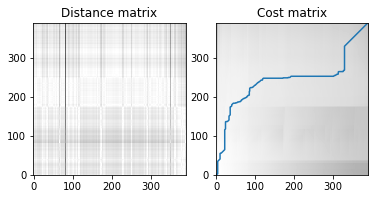

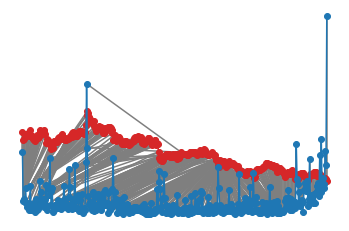

In [13]:
 # AMZN
see_ticker_stat(TICKERS[0])

#### Considerations

With Normalization, from the cost matrix graph, we can see that there are misalignments that lead the optimal path away from the diagonal. Furthermore, we can observe that the optimal path approaches the diagonal only at the opening and closing of the markets.

### Apple 

/var/folders/ff/xt97zly148d7d9kycf5fxb_00000gn/T/ipykernel_365/264788954.py:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Shape: 390 390
Alignment cost: 314.6821
Normalized alignment cost: 0.4034


/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning:

Degrees of freedom <= 0 for slice

/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning:

divide by zero encountered in true_divide

/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning:

invalid value encountered in multiply



Pearson Correlation Coefficient:  nan


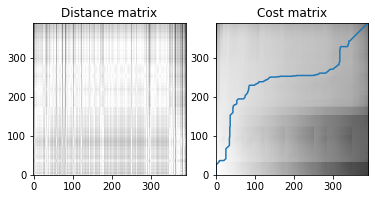

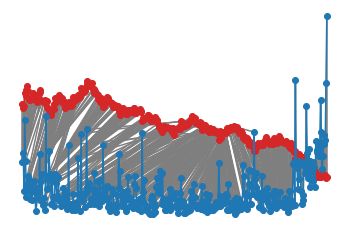

In [14]:
see_ticker_stat(TICKERS[1])


#### Considerations

With Normalization, from the cost matrix graph, we can see that there are misalignments that lead the optimal path away from the diagonal.

### Google

/var/folders/ff/xt97zly148d7d9kycf5fxb_00000gn/T/ipykernel_365/264788954.py:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Shape: 390 390
Alignment cost: 303.4604
Normalized alignment cost: 0.3891


/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning:

Degrees of freedom <= 0 for slice

/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning:

divide by zero encountered in true_divide

/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning:

invalid value encountered in multiply



Pearson Correlation Coefficient:  nan


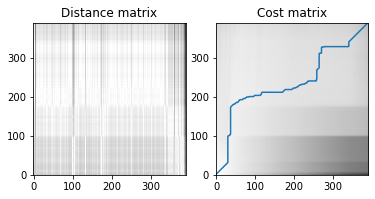

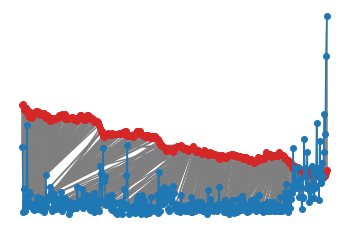

In [15]:
see_ticker_stat(TICKERS[2])


#### Considerations

With Normalization, from the cost matrix graph, we can see that there are misalignments that lead the optimal path away from the diagonal. 

### Intel

/var/folders/ff/xt97zly148d7d9kycf5fxb_00000gn/T/ipykernel_365/264788954.py:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Shape: 390 390
Alignment cost: 272.9621
Normalized alignment cost: 0.3500


/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning:

Degrees of freedom <= 0 for slice

/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning:

divide by zero encountered in true_divide

/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning:

invalid value encountered in multiply



Pearson Correlation Coefficient:  nan


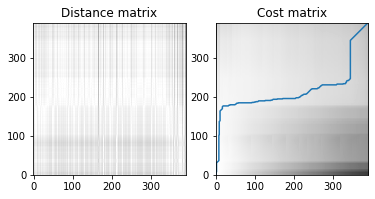

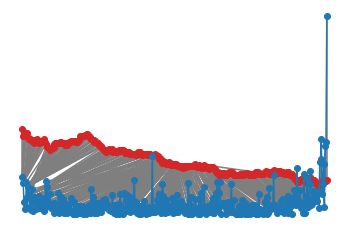

In [16]:
see_ticker_stat(TICKERS[3])


#### Considerations

With Normalization, from the cost matrix graph, we can see that there are misalignments that lead the optimal path away from the diagonal.

### Microsoft

/var/folders/ff/xt97zly148d7d9kycf5fxb_00000gn/T/ipykernel_365/264788954.py:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Shape: 390 390
Alignment cost: 263.5739
Normalized alignment cost: 0.3379


/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning:

Degrees of freedom <= 0 for slice

/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning:

divide by zero encountered in true_divide

/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning:

invalid value encountered in multiply



Pearson Correlation Coefficient:  nan


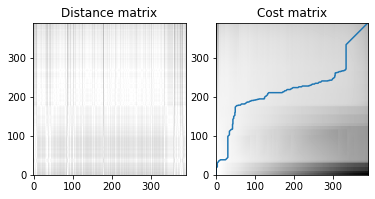

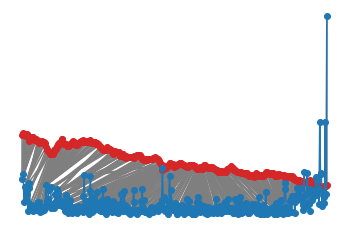

In [17]:
see_ticker_stat(TICKERS[4])


#### Considerations

With Normalization, from the cost matrix graph, we can see that there are misalignments that lead the optimal path away from the diagonal. 

## Table for Pearson Correlation Coefficient

The value will be a number between -1 and 1, where 1 is a perfect positive linear relationship, 0 is no linear relationship, and -1 is a perfect negative linear relationship. Different authors use slightly different interpretations of the coefficients, but they’re generally very similar to the ones below.

| Pearson's r value	| Strength of relationship                  |
|-------------------|-------------------------------------------|
| 0	                | No linear relationship                    |
| 0.1 to 0.3	    | Weak linear relationship                  |
| 0.3 to 0.5	    | Moderate linear relationship              |
| 0.5 to 0.7	    | Strong linear relationship                |
| 0.7 to 1	        | Very strong linear relationship           |
| -0.1 to -0.3	    | Weak negative linear relationship         |
| -0.3 to -0.5	    | Moderate negative linear relationship     |
| -0.5 to -0.7	    | Strong negative linear relationship       |
| -0.7 to -1	    | Very strong negative linear relationship  |

The Pearson Correlation Coefficient for all the stocks of our Dataframe is on the range `[0, -0.3]` this means that we have a weak negative linear relationship as we can see from the table.    